# Mood Words Dataset

In [2]:
#import libraries and modules
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder
import nltk
import sys

In [3]:
moodWords = pd.read_csv('moodWords.csv') #reads csv file of mood words
moodWords = moodWords.astype(str)
moodWords = moodWords.rename(columns=lambda x: x.lower().replace(' ', '_')) #standardizes column names
moodWords = moodWords.map(lambda x: x.lower()) #lowercase all data
moodWords #prints dataset of mood words

,sentence,label
0,regarded as one of the greatest works in liter...,adventurous
1,"in this classic by dumas, a young man named d’...",adventurous
2,written by scottish author robert louis steven...,adventurous
3,the first english adventure novel set in afric...,adventurous
4,journey to the center of the earth is exactly ...,adventurous
...,...,...
1045,don’t miss any of daniel silva’s 24 novels fea...,tense
1046,"this suspenseful thriller, tailor-made for 21s...",tense
1047,if your idea of a good fiction book is one tha...,tense
1048,"in this suspenseful novel, tom kennedy moves h...",tense


In [4]:
X = moodWords.sentence #input variables
X

0       regarded as one of the greatest works in liter...
1       in this classic by dumas, a young man named d’...
2       written by scottish author robert louis steven...
3       the first english adventure novel set in afric...
4       journey to the center of the earth is exactly ...
                              ...                        
1045    don’t miss any of daniel silva’s 24 novels fea...
1046    this suspenseful thriller, tailor-made for 21s...
1047    if your idea of a good fiction book is one tha...
1048    in this suspenseful novel, tom kennedy moves h...
1049    a female vicar and her daughter are sent, with...
Name: sentence, Length: 1050, dtype: object

In [5]:
y = moodWords.label #output variables
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Preprocess Text

In [6]:
#import libraries and modules
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [7]:
#initialize stopwords
stop_words = set(stopwords.words('english'))

#preprocess function
def preprocess(text):
    text = text.lower() #make the text lowercase
    text = ''.join([word for word in text if word not in string.punctuation]) #remove punctuations
    tokens = word_tokenize(text) #split individual words
    tokens = [word for word in tokens if word not in stop_words] #remove stop words
    return ' '.join(tokens) #join all words together

In [8]:
X = X.apply(preprocess) #preprocess text
X

0       regarded one greatest works literature quixote...
1       classic dumas young man named ’ artagnan joins...
2       written scottish author robert louis stevenson...
3       first english adventure novel set africa 1885 ...
4       journey center earth exactly trip inside world...
                              ...                        
1045    ’ miss daniel silva ’ 24 novels featuring gabr...
1046    suspenseful thriller tailormade 21stcentury re...
1047    idea good fiction book one brings setting life...
1048    suspenseful novel tom kennedy moves son new to...
1049    female vicar daughter sent without desire requ...
Name: sentence, Length: 1050, dtype: object

# Word2Vec Model

In [9]:
from gensim.models import Word2Vec

In [10]:
sentences = [sentence.split() for sentence in X] #splits sentences for every sentence in data
w2v_model = Word2Vec(sentences=sentences, vector_size=100, window=45, min_count=2, workers=5, sg=1) #trains Word2Vec model
sentences

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


[['regarded',
  'one',
  'greatest',
  'works',
  'literature',
  'quixote',
  'recounts',
  'adventures',
  'alonso',
  'quixano',
  'middleaged',
  'man',
  'obsessed',
  'chivalric',
  'books',
  'decides',
  'imitate',
  'become',
  'knighterrant',
  'begins',
  'journey',
  'find',
  'faithful',
  'squire',
  'save',
  'damsels',
  'distress',
  'fight',
  'windmills'],
 ['classic',
  'dumas',
  'young',
  'man',
  'named',
  '’',
  'artagnan',
  'joins',
  'musketeers',
  'guard',
  'befriends',
  'athos',
  'porthos',
  'aramis',
  '—',
  'king',
  '’',
  'celebrated',
  'musketeers',
  '—',
  'embarks',
  'journey'],
 ['written',
  'scottish',
  'author',
  'robert',
  'louis',
  'stevenson',
  'story',
  '“',
  'buccaneers',
  'buried',
  'gold',
  '”',
  'launched',
  'million',
  'tropes',
  'treasure',
  'maps',
  'sea',
  'chests',
  'black',
  'spots',
  'deserted',
  'islands'],
 ['first',
  'english',
  'adventure',
  'novel',
  'set',
  'africa',
  '1885',
  'book',
  

# CNN Model

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPool1D, Flatten, Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [12]:
#tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_sequence = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

vocab_size = len(tokenizer.word_index) + 1

In [13]:
#pad the sequences to a fixed length
max_length = max(len(s) for s in X_sequence)
X_pad = pad_sequences(X_sequence, maxlen=max_length, padding='post')
X_pad

array([[2857,    3,  600, ...,    0,    0,    0],
       [  55, 3906,   24, ...,    0,    0,    0],
       [ 107, 3908,   37, ...,    0,    0,    0],
       ...,
       [ 888,   95,  102, ...,    0,    0,    0],
       [1532,    7,  604, ...,    0,    0,    0],
       [1086, 3707,  147, ...,    0,    0,    0]])

In [14]:
#create a weight matrix for the embedding layer
embedding_dim=100
embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [15]:
#split data for training and testing (test size is 30%)
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=.30, random_state=42, stratify=y)

In [16]:
#define CNN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=True))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(14, activation='softmax'))

In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, batch_size=35, validation_data=(X_test, y_test))
metrics_df = pd.DataFrame(history.history)

Epoch 1/15
21/21 [==============================] - 3s 75ms/step - loss: 2.6140 - accuracy: 0.1007 - val_loss: 2.5542 - val_accuracy: 0.1651
Epoch 2/15
21/21 [==============================] - 1s 51ms/step - loss: 2.4476 - accuracy: 0.2340 - val_loss: 2.4115 - val_accuracy: 0.2222
Epoch 3/15
21/21 [==============================] - 1s 50ms/step - loss: 2.1916 - accuracy: 0.3782 - val_loss: 2.2296 - val_accuracy: 0.2889
Epoch 4/15
21/21 [==============================] - 1s 49ms/step - loss: 1.8517 - accuracy: 0.4816 - val_loss: 2.0709 - val_accuracy: 0.3397
Epoch 5/15
21/21 [==============================] - 1s 50ms/step - loss: 1.4630 - accuracy: 0.6463 - val_loss: 1.9247 - val_accuracy: 0.3841
Epoch 6/15
21/21 [==============================] - 1s 53ms/step - loss: 1.0696 - accuracy: 0.7946 - val_loss: 1.8645 - val_accuracy: 0.3778
Epoch 7/15
21/21 [==============================] - 1s 52ms/step - loss: 0.7043 - accuracy: 0.8898 - val_loss: 1.8217 - val_accuracy: 0.4190
Epoch 8/15
21

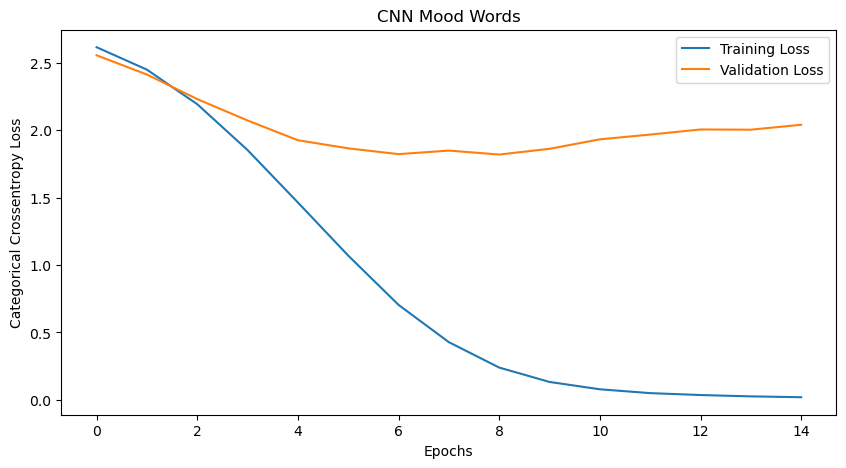

In [18]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('CNN Mood Words')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()